# Importing Dependencies


In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Reading the data


In [38]:
df = pd.read_csv("dataFiles/HINDUNILVR_cleaned.csv")

df = df[['Close','Open','Date']]
df['LogReturn'] = np.log(df['Close'] / df['Close'].shift(1))
df.head()

,Close,Open,Date,LogReturn
0,34.623840,34.845124,1996-01-01 00:00:00+05:30,NaN
1,34.993568,34.623829,1996-01-02 00:00:00+05:30,0.010622
2,34.786304,34.993582,1996-01-03 00:00:00+05:30,-0.005941
3,34.789097,34.733077,1996-01-04 00:00:00+05:30,0.000080
4,34.733078,34.789098,1996-01-05 00:00:00+05:30,-0.001612


# Plots

In [39]:
# sns.lineplot(data = df, x = "Date", y = "Close")

In [40]:
# sns.lineplot(data = df, x = "Date", y = "LogReturn")

In [41]:
train = df['Close']

series_close = train.dropna().values.reshape(-1, 1)

series_close = df['Close']
series_close.index = pd.to_datetime(series_close.index)
split = int(len(series_close) * 0.8)
train_close, test_close = series_close[:split], series_close[split:]


# RNN

In [42]:
train = df['LogReturn']

# Example: assuming `train` is a Pandas Series
series = train.dropna().values.reshape(-1, 1)

# Scale data to [0,1]
scaler = MinMaxScaler()
scaled_series = scaler.fit_transform(series)

# Convert to sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 10
X, y = create_sequences(scaled_series, window_size)

# Train-test split
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]



In [59]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

model = Sequential([
    SimpleRNN(50, activation='tanh', input_shape=(window_size, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()


history = model.fit(X_train, y_train, epochs=1000, batch_size=16, validation_data=(X_test, y_test), verbose=1)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_6 (SimpleRNN)        │ (None, 50)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0155 - val_loss: 0.0023
Epoch 2/1000
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - loss: 0.0039 - val_loss: 0.0021
Epoch 3/1000
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0037 - val_loss: 0.0021
Epoch 4/1000
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - loss: 0.0037 - val_loss: 0.0022
Epoch 5/1000
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 0.0036 - val_loss: 0.0021
Epoch 6/1000
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0038 - val_loss: 0.0021
Epoch 7/1000
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0035 - val_loss: 0.0021
Epoch 8/1000
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - loss: 0.0034 - val_loss: 0.0021
Epoch 9/1000
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 0.0033 - val_loss: 0.0021
Epoch 10/1000
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0037 - val_loss: 0.0023
Epoch 11/1000
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 0.0035 - val_loss: 0.0021
Epoch 12/1000
369/

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step
RMSE: 0.0187
MAE: 0.0132
Directional Accuracy: 49.66%
R²: 0.0081


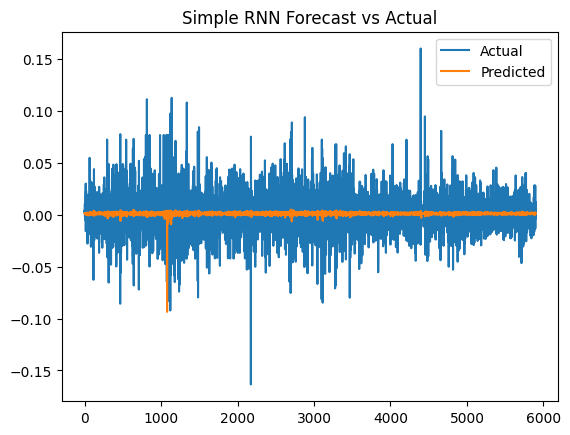

In [77]:
# Predict
y_pred_scaled = model.predict(X_train)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_train_orig = scaler.inverse_transform(y_train)

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(y_train_orig, y_pred))
mae = mean_absolute_error(y_train_orig, y_pred)
directional_accuracy = (np.sign(y_train_orig.flatten()) == np.sign(y_pred.flatten())).mean()
r2_forecast = r2_score(y_train_orig, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Directional Accuracy: {directional_accuracy:.2%}")
print(f'R²: {r2_forecast:.4f}')


y_actual = y_train_orig


import matplotlib.pyplot as plt

plt.plot(y_train_orig, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title("Simple RNN Forecast vs Actual")
plt.show()

# print(y_pred)
# print(y_train_orig)


In [78]:
# y_pred_scaled = model.predict(X_train)
# y_pred = scaler.inverse_transform(y_pred_scaled)
# y_train_orig = scaler.inverse_transform(y_train)

In [87]:
first_close = df['Close'].iloc[0]

# Reconstruct the Close prices
recClose = first_close * np.exp(y_pred.cumsum())
recClose = pd.Series(recClose)
# print(recClose)
print(train_close)



1970-01-01 00:00:00.000000027      37.570541
1970-01-01 00:00:00.000000028      38.430450
1970-01-01 00:00:00.000000029      38.231586
1970-01-01 00:00:00.000000030      39.130730
1970-01-01 00:00:00.000000031      39.741360
                                    ...     
1970-01-01 00:00:00.000005902    1628.365845
1970-01-01 00:00:00.000005903    1632.244263
1970-01-01 00:00:00.000005904    1678.971313
1970-01-01 00:00:00.000005905    1656.976685
1970-01-01 00:00:00.000005906    1677.191650
Name: Close, Length: 5880, dtype: float64


RMSE = 7164.6782
MAE  = 3744.3389
Directional Accuracy = 49.66%
R²: -358.0547


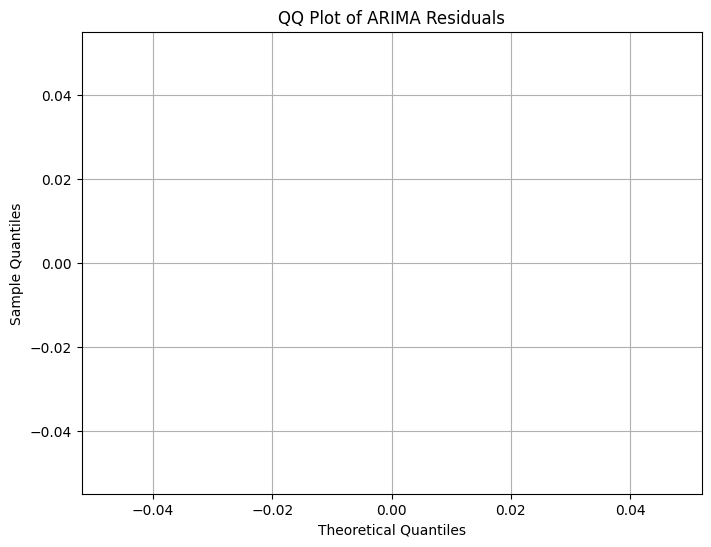

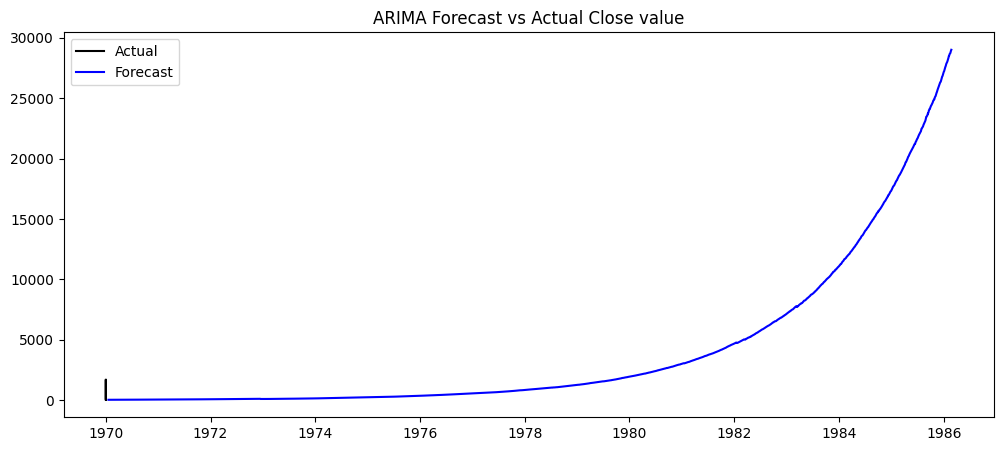

In [88]:
# eval_df = pd.DataFrame({'actual': train_close, 'predicted': recClose}).dropna()
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.graphics.gofplots import qqplot

# trimmed_train = train_close[-len(recClose):]
# train_close = train_close[2:]
recClose = recClose[18:]

rmse = np.sqrt(mean_squared_error(train_close, recClose))
mae = mean_absolute_error(train_close, recClose)
# directional_accuracy = (np.sign(train_close) == np.sign(recClose)).mean()
r2_forecast = r2_score(train_close, recClose)


print(f"RMSE = {rmse:.4f}")
print(f"MAE  = {mae:.4f}")
print(f"Directional Accuracy = {directional_accuracy:.2%}")
print(f'R²: {r2_forecast:.4f}')

residuals = train_close - recClose
plt.figure(figsize=(8, 6))
qqplot(residuals, line='s', ax=plt.gca())
plt.title('QQ Plot of ARIMA Residuals')
plt.grid(True)
plt.show()

plt.figure(figsize=(12,5))
plt.plot( train_close, label='Actual', color = 'black')
plt.plot( recClose, label='Forecast', color = 'blue')
plt.legend()
plt.title('ARIMA Forecast vs Actual Close value')
plt.show()